In [3]:
from __future__ import print_function
import sys
sys.path.insert(0, '..')
import os
import matplotlib as mpl
import tarfile
import matplotlib.image as mpimg
from matplotlib import pyplot as plt
import gluonbook as gb
import mxnet as mx
from mxnet import gluon
from mxnet import ndarray as nd
from mxnet.gluon import nn, utils
from mxnet import autograd
import numpy as np

C:\Users\weij\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [19]:

epochs = 30 # Set low by default for tests, set higher when you actually run this code.
batch_size = 64
latent_z_size = 100

ctx = gb.try_gpu()

lr = 0.0002
beta1 = 0.5

In [5]:
lfw_url = 'http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz'
data_path = 'lfw_dataset'
if not os.path.exists(data_path):
    os.makedirs(data_path)
    data_file = utils.download(lfw_url)
    with tarfile.open(data_file) as tar:
        tar.extractall(path=data_path)

In [6]:
target_wd = 64
target_ht = 64
img_list = []

def transform(data, target_wd, target_ht):
    # resize to target_wd * target_ht
    data = mx.image.imresize(data, target_wd, target_ht)
    # transpose from (target_wd, target_ht, 3)
    # to (3, target_wd, target_ht)
    data = nd.transpose(data, (2,0,1))
    # normalize to [-1, 1]
    data = data.astype(np.float32)/127.5 - 1
    # if image is greyscale, repeat 3 times to get RGB image.
    if data.shape[0] == 1:
        data = nd.tile(data, (3, 1, 1))
    return data.reshape((1,) + data.shape)

for path, _, fnames in os.walk(data_path):
    for fname in fnames:
        if not fname.endswith('.jpg'):
            continue
        img = os.path.join(path, fname)
        img_arr = mx.image.imread(img)
        img_arr = transform(img_arr, target_wd, target_ht)
        img_list.append(img_arr)
train_data = mx.io.NDArrayIter(data=nd.concatenate(img_list), batch_size=batch_size)

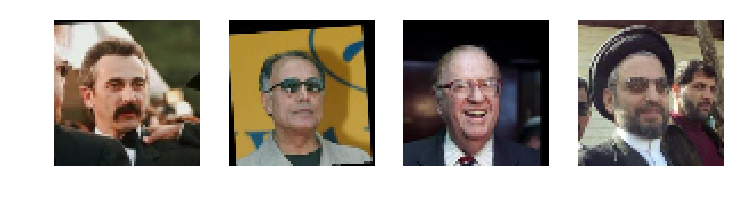

In [7]:
def visualize(img_arr):
    plt.imshow(((img_arr.asnumpy().transpose(1, 2, 0) + 1.0) * 127.5).astype(np.uint8))
    plt.axis('off')

for i in range(4):
    plt.subplot(1,4,i+1)
    visualize(img_list[i + 10][0])
plt.show()

In [8]:
nc = 3
ngf = 64
netG = nn.Sequential()
with netG.name_scope():
    # input is Z, going into a convolution
    netG.add(nn.Conv2DTranspose(ngf * 8, 4, 1, 0, use_bias=False))
    netG.add(nn.BatchNorm())
    netG.add(nn.Activation('relu'))
    # state size. (ngf*8) x 4 x 4
    netG.add(nn.Conv2DTranspose(ngf * 4, 4, 2, 1, use_bias=False))
    netG.add(nn.BatchNorm())
    netG.add(nn.Activation('relu'))
    # state size. (ngf*8) x 8 x 8
    netG.add(nn.Conv2DTranspose(ngf * 2, 4, 2, 1, use_bias=False))
    netG.add(nn.BatchNorm())
    netG.add(nn.Activation('relu'))
    # state size. (ngf*8) x 16 x 16
    netG.add(nn.Conv2DTranspose(ngf, 4, 2, 1, use_bias=False))
    netG.add(nn.BatchNorm())
    netG.add(nn.Activation('relu'))
    # state size. (ngf*8) x 32 x 32
    netG.add(nn.Conv2DTranspose(nc, 4, 2, 1, use_bias=False))
    netG.add(nn.Activation('tanh'))
    # state size. (nc) x 64 x 64

# build the discriminator
ndf = 64
netD = nn.Sequential()
with netD.name_scope():
    # input is (nc) x 64 x 64
    netD.add(nn.Conv2D(ndf, 4, 2, 1, use_bias=False))
    netD.add(nn.LeakyReLU(0.2))
    # state size. (ndf) x 32 x 32
    netD.add(nn.Conv2D(ndf * 2, 4, 2, 1, use_bias=False))
    netD.add(nn.BatchNorm())
    netD.add(nn.LeakyReLU(0.2))
    # state size. (ndf) x 16 x 16
    netD.add(nn.Conv2D(ndf * 4, 4, 2, 1, use_bias=False))
    netD.add(nn.BatchNorm())
    netD.add(nn.LeakyReLU(0.2))
    # state size. (ndf) x 8 x 8
    netD.add(nn.Conv2D(ndf * 8, 4, 2, 1, use_bias=False))
    netD.add(nn.BatchNorm())
    netD.add(nn.LeakyReLU(0.2))
    # state size. (ndf) x 4 x 4
    netD.add(nn.Conv2D(1, 4, 1, 0, use_bias=False))


In [9]:
loss = gluon.loss.SigmoidBinaryCrossEntropyLoss()

# initialize the generator and the discriminator
netG.initialize(mx.init.Normal(0.02), ctx=ctx)
netD.initialize(mx.init.Normal(0.02), ctx=ctx)

# trainer for the generator and the discriminator
trainerG = gluon.Trainer(netG.collect_params(), 'adam', {'learning_rate': lr, 'beta1': beta1})
trainerD = gluon.Trainer(netD.collect_params(), 'adam', {'learning_rate': lr, 'beta1': beta1})


INFO:root:speed: 2001.9648285428755 samples/s
INFO:root:discriminator loss = 0.029728, generator loss = 6.998711, binary training acc = 1.000000 at iter 0 epoch 0
INFO:root:speed: 969.6516578347547 samples/s
INFO:root:discriminator loss = 0.021744, generator loss = 6.402250, binary training acc = 1.000000 at iter 10 epoch 0
INFO:root:speed: 970.1107167896612 samples/s
INFO:root:discriminator loss = 0.013275, generator loss = 7.131158, binary training acc = 1.000000 at iter 20 epoch 0
INFO:root:speed: 984.1668903114162 samples/s
INFO:root:discriminator loss = 0.011932, generator loss = 6.420155, binary training acc = 1.000000 at iter 30 epoch 0
INFO:root:speed: 955.2251314862393 samples/s
INFO:root:discriminator loss = 0.018198, generator loss = 5.481107, binary training acc = 1.000000 at iter 40 epoch 0
INFO:root:speed: 999.9644470934455 samples/s
INFO:root:discriminator loss = 0.030231, generator loss = 7.295796, binary training acc = 1.000000 at iter 50 epoch 0
INFO:root:speed: 984.6

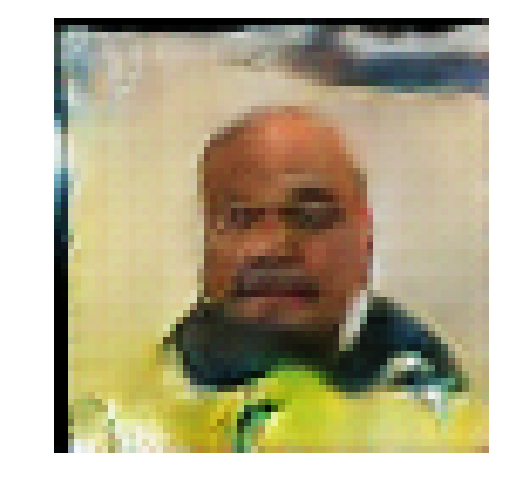

INFO:root:speed: 2133.2166947455416 samples/s
INFO:root:discriminator loss = 0.406463, generator loss = 9.093096, binary training acc = 0.937500 at iter 0 epoch 1
INFO:root:speed: 984.7228760088041 samples/s
INFO:root:discriminator loss = 0.070553, generator loss = 5.850982, binary training acc = 0.973722 at iter 10 epoch 1
INFO:root:speed: 985.0083333027546 samples/s
INFO:root:discriminator loss = 0.500875, generator loss = 11.262159, binary training acc = 0.969122 at iter 20 epoch 1
INFO:root:speed: 984.6542464024884 samples/s
INFO:root:discriminator loss = 0.203847, generator loss = 7.694773, binary training acc = 0.969506 at iter 30 epoch 1
INFO:root:speed: 999.9644470934455 samples/s
INFO:root:discriminator loss = 0.103123, generator loss = 5.254463, binary training acc = 0.973133 at iter 40 epoch 1
INFO:root:speed: 999.990522951296 samples/s
INFO:root:discriminator loss = 0.087422, generator loss = 5.859759, binary training acc = 0.976103 at iter 50 epoch 1
INFO:root:speed: 984.6

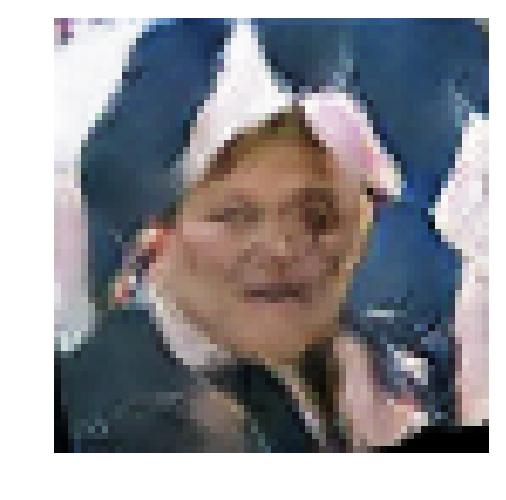

INFO:root:speed: 2285.549097906325 samples/s
INFO:root:discriminator loss = 0.027685, generator loss = 6.596907, binary training acc = 1.000000 at iter 0 epoch 2
INFO:root:speed: 984.6072948149887 samples/s
INFO:root:discriminator loss = 0.038273, generator loss = 5.993520, binary training acc = 0.999290 at iter 10 epoch 2
INFO:root:speed: 955.2183332147179 samples/s
INFO:root:discriminator loss = 0.016982, generator loss = 6.521841, binary training acc = 0.998884 at iter 20 epoch 2
INFO:root:speed: 969.7287213481928 samples/s
INFO:root:discriminator loss = 0.045057, generator loss = 5.704646, binary training acc = 0.998992 at iter 30 epoch 2
INFO:root:speed: 984.5928490734899 samples/s
INFO:root:discriminator loss = 0.041486, generator loss = 6.508040, binary training acc = 0.999238 at iter 40 epoch 2
INFO:root:speed: 999.6069724920961 samples/s
INFO:root:discriminator loss = 0.026511, generator loss = 6.344035, binary training acc = 0.999234 at iter 50 epoch 2
INFO:root:speed: 954.79

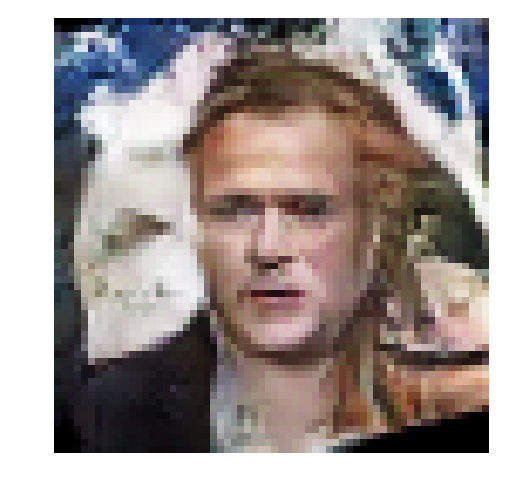

INFO:root:speed: 2367.698555224302 samples/s
INFO:root:discriminator loss = 0.031989, generator loss = 6.214298, binary training acc = 1.000000 at iter 0 epoch 3
INFO:root:speed: 1015.8120920164839 samples/s
INFO:root:discriminator loss = 0.056335, generator loss = 5.774453, binary training acc = 0.997869 at iter 10 epoch 3
INFO:root:speed: 969.3820319666033 samples/s
INFO:root:discriminator loss = 0.030524, generator loss = 6.602147, binary training acc = 0.998884 at iter 20 epoch 3
INFO:root:speed: 984.2174085209357 samples/s
INFO:root:discriminator loss = 0.047782, generator loss = 5.150164, binary training acc = 0.998992 at iter 30 epoch 3
INFO:root:speed: 984.6036833398745 samples/s
INFO:root:discriminator loss = 0.068921, generator loss = 7.293889, binary training acc = 0.999047 at iter 40 epoch 3
INFO:root:speed: 969.3470266210223 samples/s
INFO:root:discriminator loss = 0.127989, generator loss = 7.260824, binary training acc = 0.998315 at iter 50 epoch 3
INFO:root:speed: 984.9

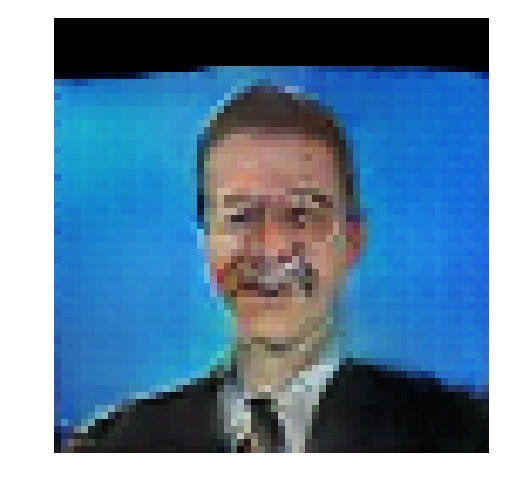

INFO:root:speed: 2370.437519316867 samples/s
INFO:root:discriminator loss = 0.021887, generator loss = 6.291926, binary training acc = 1.000000 at iter 0 epoch 4
INFO:root:speed: 955.2285306582876 samples/s
INFO:root:discriminator loss = 0.035571, generator loss = 6.905023, binary training acc = 0.998580 at iter 10 epoch 4
INFO:root:speed: 970.1492835071107 samples/s
INFO:root:discriminator loss = 0.024387, generator loss = 6.274346, binary training acc = 0.999256 at iter 20 epoch 4
INFO:root:speed: 955.1877421903077 samples/s
INFO:root:discriminator loss = 0.029723, generator loss = 5.570704, binary training acc = 0.999244 at iter 30 epoch 4
INFO:root:speed: 969.6866851860548 samples/s
INFO:root:discriminator loss = 0.042135, generator loss = 6.428994, binary training acc = 0.999238 at iter 40 epoch 4
INFO:root:speed: 955.2523255400164 samples/s
INFO:root:discriminator loss = 0.031971, generator loss = 5.788763, binary training acc = 0.999387 at iter 50 epoch 4
INFO:root:speed: 969.89

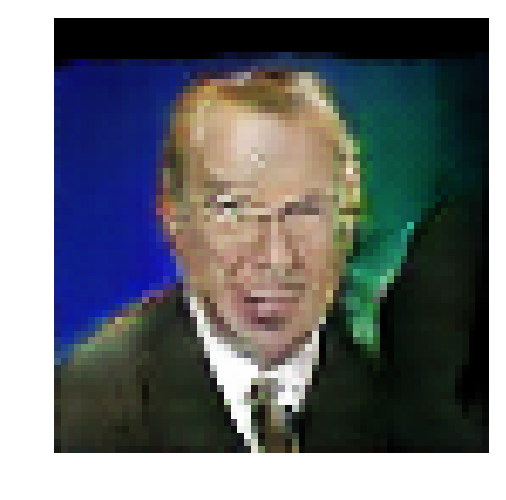

INFO:root:speed: 2349.051017729317 samples/s
INFO:root:discriminator loss = 0.022294, generator loss = 6.555685, binary training acc = 1.000000 at iter 0 epoch 5
INFO:root:speed: 955.2115350399613 samples/s
INFO:root:discriminator loss = 0.027897, generator loss = 5.638231, binary training acc = 1.000000 at iter 10 epoch 5
INFO:root:speed: 955.2353290749604 samples/s
INFO:root:discriminator loss = 0.014664, generator loss = 6.846483, binary training acc = 1.000000 at iter 20 epoch 5
INFO:root:speed: 955.2081359888692 samples/s
INFO:root:discriminator loss = 0.023318, generator loss = 6.243143, binary training acc = 1.000000 at iter 30 epoch 5
INFO:root:speed: 985.1023174737151 samples/s
INFO:root:discriminator loss = 0.019305, generator loss = 5.844450, binary training acc = 1.000000 at iter 40 epoch 5
INFO:root:speed: 969.7006968351618 samples/s
INFO:root:discriminator loss = 0.011927, generator loss = 6.617285, binary training acc = 0.999847 at iter 50 epoch 5
INFO:root:speed: 955.21

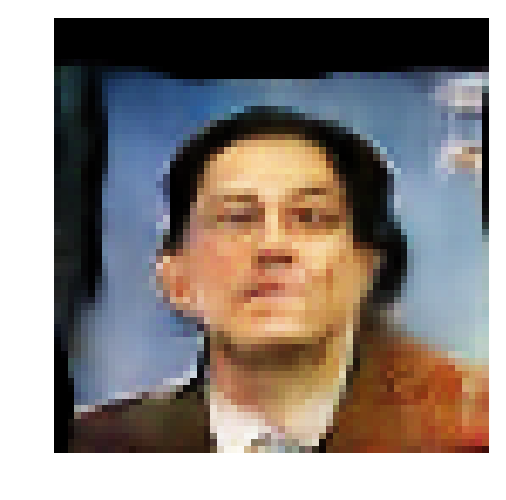

INFO:root:speed: 2203.8673913400435 samples/s
INFO:root:discriminator loss = 0.019112, generator loss = 7.088489, binary training acc = 1.000000 at iter 0 epoch 6
INFO:root:speed: 955.2387283195854 samples/s
INFO:root:discriminator loss = 0.022356, generator loss = 6.653854, binary training acc = 1.000000 at iter 10 epoch 6
INFO:root:speed: 941.17208832666 samples/s
INFO:root:discriminator loss = 0.019000, generator loss = 6.892536, binary training acc = 1.000000 at iter 20 epoch 6
INFO:root:speed: 941.16878845783 samples/s
INFO:root:discriminator loss = 0.031538, generator loss = 6.865267, binary training acc = 1.000000 at iter 30 epoch 6
INFO:root:speed: 940.8718949895725 samples/s
INFO:root:discriminator loss = 0.011454, generator loss = 6.202568, binary training acc = 1.000000 at iter 40 epoch 6
INFO:root:speed: 927.9112862525493 samples/s
INFO:root:discriminator loss = 0.028180, generator loss = 7.541361, binary training acc = 1.000000 at iter 50 epoch 6
INFO:root:speed: 940.81583

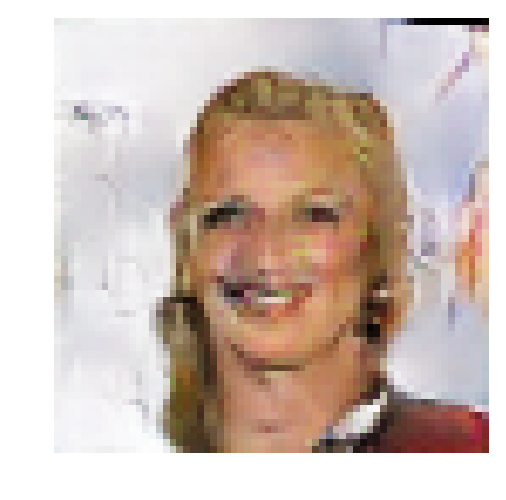

INFO:root:speed: 2369.8097163489974 samples/s
INFO:root:discriminator loss = 0.020844, generator loss = 6.747322, binary training acc = 1.000000 at iter 0 epoch 7
INFO:root:speed: 876.420913786461 samples/s
INFO:root:discriminator loss = 0.014141, generator loss = 6.411826, binary training acc = 1.000000 at iter 10 epoch 7
INFO:root:speed: 876.7071518619401 samples/s
INFO:root:discriminator loss = 0.014969, generator loss = 6.717789, binary training acc = 1.000000 at iter 20 epoch 7
INFO:root:speed: 941.2083884110616 samples/s
INFO:root:discriminator loss = 0.011914, generator loss = 6.923871, binary training acc = 1.000000 at iter 30 epoch 7
INFO:root:speed: 927.8824192271663 samples/s
INFO:root:discriminator loss = 0.025789, generator loss = 6.878495, binary training acc = 1.000000 at iter 40 epoch 7
INFO:root:speed: 914.3146134772064 samples/s
INFO:root:discriminator loss = 0.015775, generator loss = 7.215578, binary training acc = 1.000000 at iter 50 epoch 7
INFO:root:speed: 941.13

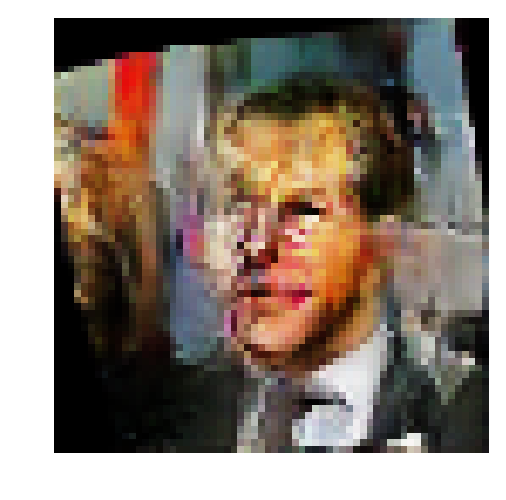

INFO:root:speed: 2372.784258956431 samples/s
INFO:root:discriminator loss = 0.758549, generator loss = 6.861348, binary training acc = 0.875000 at iter 0 epoch 8
INFO:root:speed: 913.9752877926871 samples/s
INFO:root:discriminator loss = 0.512919, generator loss = 5.358312, binary training acc = 0.796165 at iter 10 epoch 8
INFO:root:speed: 914.2803581707271 samples/s
INFO:root:discriminator loss = 0.702753, generator loss = 2.695057, binary training acc = 0.823661 at iter 20 epoch 8
INFO:root:speed: 864.8718199860814 samples/s
INFO:root:discriminator loss = 0.308259, generator loss = 5.091007, binary training acc = 0.832913 at iter 30 epoch 8
INFO:root:speed: 901.7372475116481 samples/s
INFO:root:discriminator loss = 0.882313, generator loss = 3.777489, binary training acc = 0.847180 at iter 40 epoch 8
INFO:root:speed: 927.5906423857078 samples/s
INFO:root:discriminator loss = 2.186656, generator loss = 9.688240, binary training acc = 0.847886 at iter 50 epoch 8
INFO:root:speed: 914.28

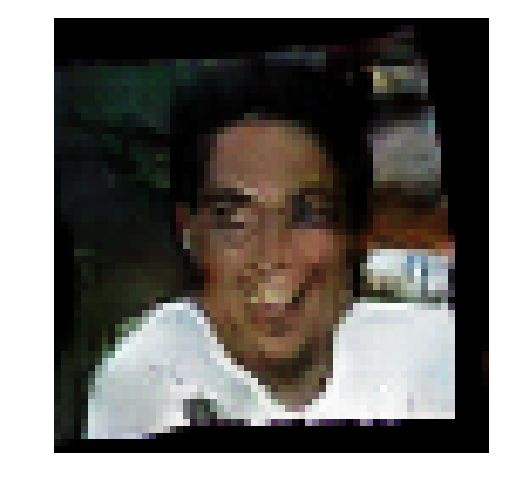

INFO:root:speed: 2372.3858241272646 samples/s
INFO:root:discriminator loss = 0.275788, generator loss = 3.612337, binary training acc = 0.921875 at iter 0 epoch 9
INFO:root:speed: 888.8620690796989 samples/s
INFO:root:discriminator loss = 0.134666, generator loss = 6.152393, binary training acc = 0.978693 at iter 10 epoch 9
INFO:root:speed: 927.8760045765483 samples/s
INFO:root:discriminator loss = 0.052650, generator loss = 6.851041, binary training acc = 0.984375 at iter 20 epoch 9
INFO:root:speed: 901.3860034989574 samples/s
INFO:root:discriminator loss = 0.065831, generator loss = 5.370027, binary training acc = 0.988155 at iter 30 epoch 9
INFO:root:speed: 914.6230267842844 samples/s
INFO:root:discriminator loss = 0.126344, generator loss = 7.732643, binary training acc = 0.990091 at iter 40 epoch 9
INFO:root:speed: 927.8760045765483 samples/s
INFO:root:discriminator loss = 0.051006, generator loss = 7.169291, binary training acc = 0.989277 at iter 50 epoch 9
INFO:root:speed: 913.9

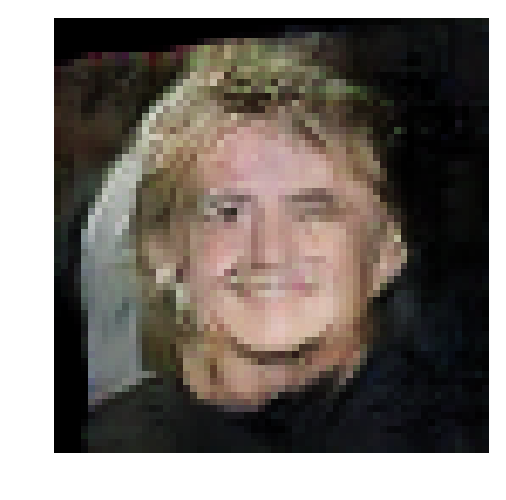

INFO:root:speed: 2285.1794190758333 samples/s
INFO:root:discriminator loss = 0.053487, generator loss = 6.237312, binary training acc = 1.000000 at iter 0 epoch 10
INFO:root:speed: 927.5041065314063 samples/s
INFO:root:discriminator loss = 0.061388, generator loss = 6.273872, binary training acc = 0.996449 at iter 10 epoch 10
INFO:root:speed: 914.2087417326803 samples/s
INFO:root:discriminator loss = 0.012985, generator loss = 6.678581, binary training acc = 0.997396 at iter 20 epoch 10
INFO:root:speed: 914.6261431316697 samples/s
INFO:root:discriminator loss = 0.043945, generator loss = 6.691948, binary training acc = 0.998236 at iter 30 epoch 10
INFO:root:speed: 901.398110806282 samples/s
INFO:root:discriminator loss = 0.036834, generator loss = 5.770317, binary training acc = 0.998095 at iter 40 epoch 10
INFO:root:speed: 914.2461054309399 samples/s
INFO:root:discriminator loss = 1.241178, generator loss = 3.652080, binary training acc = 0.941023 at iter 50 epoch 10
INFO:root:speed: 

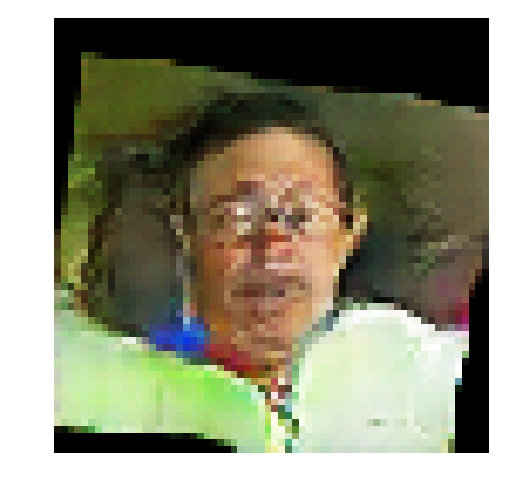

INFO:root:speed: 2133.369276864266 samples/s
INFO:root:discriminator loss = 0.056687, generator loss = 6.490685, binary training acc = 1.000000 at iter 0 epoch 11
INFO:root:speed: 901.4041645819132 samples/s
INFO:root:discriminator loss = 0.069631, generator loss = 5.283345, binary training acc = 0.997159 at iter 10 epoch 11
INFO:root:speed: 901.4071915002216 samples/s
INFO:root:discriminator loss = 0.098842, generator loss = 6.418861, binary training acc = 0.996652 at iter 20 epoch 11
INFO:root:speed: 889.2006731062262 samples/s
INFO:root:discriminator loss = 0.066327, generator loss = 6.499924, binary training acc = 0.997732 at iter 30 epoch 11
INFO:root:speed: 888.8856157964973 samples/s
INFO:root:discriminator loss = 0.056592, generator loss = 5.549600, binary training acc = 0.997142 at iter 40 epoch 11
INFO:root:speed: 901.4283804976006 samples/s
INFO:root:discriminator loss = 0.059819, generator loss = 6.093235, binary training acc = 0.995864 at iter 50 epoch 11
INFO:root:speed: 

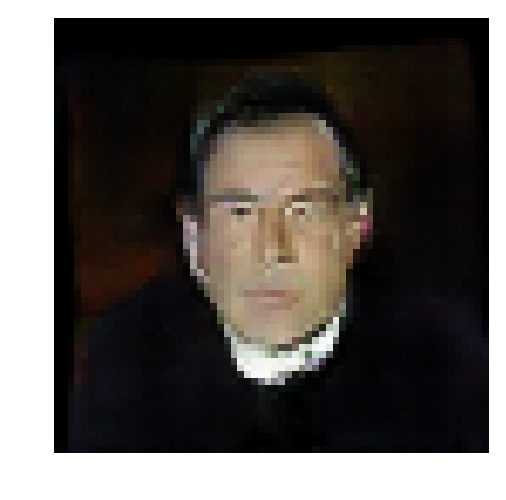

INFO:root:speed: 2204.1931288182354 samples/s
INFO:root:discriminator loss = 0.048738, generator loss = 6.821006, binary training acc = 1.000000 at iter 0 epoch 12
INFO:root:speed: 913.9441696089012 samples/s
INFO:root:discriminator loss = 0.051345, generator loss = 6.679228, binary training acc = 0.998580 at iter 10 epoch 12
INFO:root:speed: 901.7493642566085 samples/s
INFO:root:discriminator loss = 0.022769, generator loss = 6.373579, binary training acc = 0.999256 at iter 20 epoch 12
INFO:root:speed: 927.9177013910014 samples/s
INFO:root:discriminator loss = 0.065319, generator loss = 6.431859, binary training acc = 0.999496 at iter 30 epoch 12
INFO:root:speed: 914.283472183432 samples/s
INFO:root:discriminator loss = 0.025220, generator loss = 6.364709, binary training acc = 0.999619 at iter 40 epoch 12
INFO:root:speed: 914.0095202424325 samples/s
INFO:root:discriminator loss = 0.028662, generator loss = 5.807636, binary training acc = 0.999694 at iter 50 epoch 12
INFO:root:speed: 

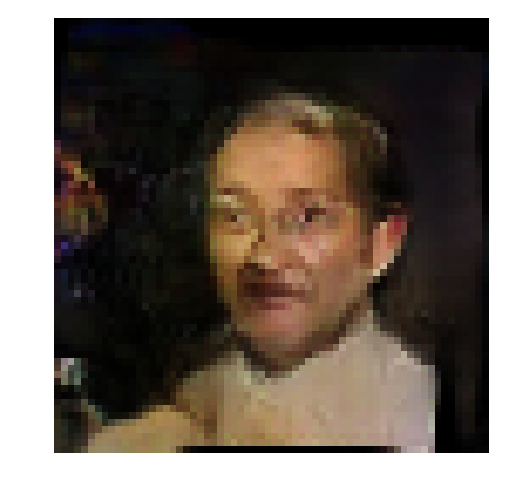

INFO:root:speed: 2064.4117203722217 samples/s
INFO:root:discriminator loss = 0.015385, generator loss = 5.792374, binary training acc = 1.000000 at iter 0 epoch 13
INFO:root:speed: 914.3519858300974 samples/s
INFO:root:discriminator loss = 0.022799, generator loss = 6.064665, binary training acc = 1.000000 at iter 10 epoch 13
INFO:root:speed: 864.793804203554 samples/s
INFO:root:discriminator loss = 0.011477, generator loss = 6.245597, binary training acc = 1.000000 at iter 20 epoch 13
INFO:root:speed: 927.5073112751196 samples/s
INFO:root:discriminator loss = 0.021524, generator loss = 6.220998, binary training acc = 1.000000 at iter 30 epoch 13
INFO:root:speed: 927.1132938913238 samples/s
INFO:root:discriminator loss = 0.025463, generator loss = 6.969169, binary training acc = 0.999809 at iter 40 epoch 13
INFO:root:speed: 914.249219210321 samples/s
INFO:root:discriminator loss = 0.027470, generator loss = 5.690890, binary training acc = 0.999847 at iter 50 epoch 13
INFO:root:speed: 9

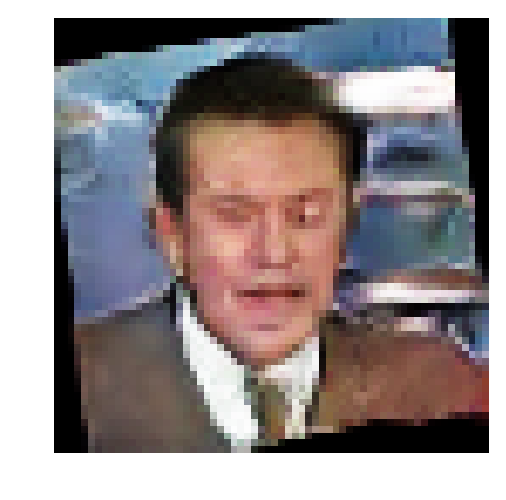

INFO:root:speed: 2206.6573720899646 samples/s
INFO:root:discriminator loss = 0.027908, generator loss = 7.028466, binary training acc = 1.000000 at iter 0 epoch 14
INFO:root:speed: 927.4976971104178 samples/s
INFO:root:discriminator loss = 0.019402, generator loss = 5.587460, binary training acc = 1.000000 at iter 10 epoch 14
INFO:root:speed: 914.2523330109124 samples/s
INFO:root:discriminator loss = 0.018295, generator loss = 6.179277, binary training acc = 1.000000 at iter 20 epoch 14
INFO:root:speed: 914.283472183432 samples/s
INFO:root:discriminator loss = 0.019964, generator loss = 6.043869, binary training acc = 1.000000 at iter 30 epoch 14
INFO:root:speed: 914.283472183432 samples/s
INFO:root:discriminator loss = 0.019943, generator loss = 5.894708, binary training acc = 1.000000 at iter 40 epoch 14
INFO:root:speed: 901.4011376839334 samples/s
INFO:root:discriminator loss = 0.022911, generator loss = 5.671801, binary training acc = 1.000000 at iter 50 epoch 14
INFO:root:speed: 9

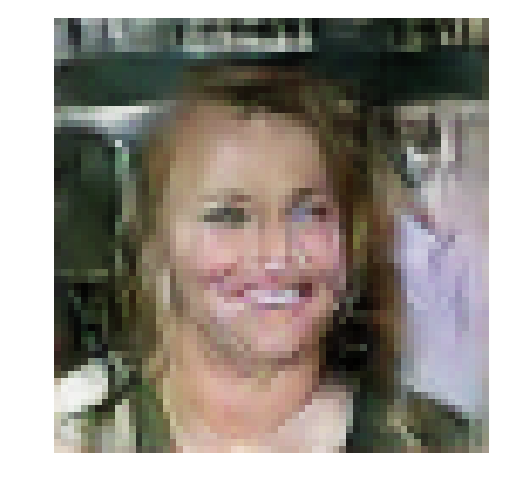

INFO:root:speed: 1999.6234887480166 samples/s
INFO:root:discriminator loss = 0.017492, generator loss = 6.699636, binary training acc = 1.000000 at iter 0 epoch 15
INFO:root:speed: 901.4374618014278 samples/s
INFO:root:discriminator loss = 0.026552, generator loss = 6.926005, binary training acc = 1.000000 at iter 10 epoch 15
INFO:root:speed: 888.5590164911189 samples/s
INFO:root:discriminator loss = 0.015051, generator loss = 6.691369, binary training acc = 1.000000 at iter 20 epoch 15
INFO:root:speed: 876.7271955294125 samples/s
INFO:root:discriminator loss = 0.020074, generator loss = 6.548163, binary training acc = 1.000000 at iter 30 epoch 15
INFO:root:speed: 888.8473530151919 samples/s
INFO:root:discriminator loss = 0.014364, generator loss = 6.932987, binary training acc = 1.000000 at iter 40 epoch 15
INFO:root:speed: 888.5619577558499 samples/s
INFO:root:discriminator loss = 0.021708, generator loss = 6.404896, binary training acc = 1.000000 at iter 50 epoch 15
INFO:root:speed:

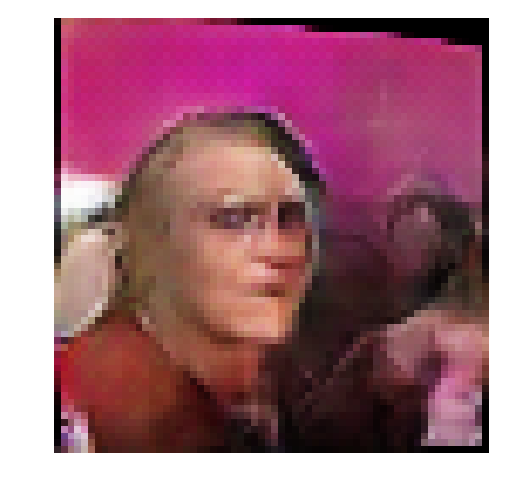

INFO:root:speed: 2283.857337326436 samples/s
INFO:root:discriminator loss = 0.019878, generator loss = 5.697936, binary training acc = 1.000000 at iter 0 epoch 16
INFO:root:speed: 940.7400024531707 samples/s
INFO:root:discriminator loss = 0.113591, generator loss = 7.914599, binary training acc = 0.995739 at iter 10 epoch 16
INFO:root:speed: 913.9690639864081 samples/s
INFO:root:discriminator loss = 0.019453, generator loss = 6.766282, binary training acc = 0.994048 at iter 20 epoch 16
INFO:root:speed: 913.8881622175543 samples/s
INFO:root:discriminator loss = 0.064895, generator loss = 5.895652, binary training acc = 0.993952 at iter 30 epoch 16
INFO:root:speed: 888.8885592238154 samples/s
INFO:root:discriminator loss = 0.067454, generator loss = 7.578428, binary training acc = 0.994474 at iter 40 epoch 16
INFO:root:speed: 913.8570499661264 samples/s
INFO:root:discriminator loss = 0.077186, generator loss = 6.645153, binary training acc = 0.995098 at iter 50 epoch 16
INFO:root:speed: 

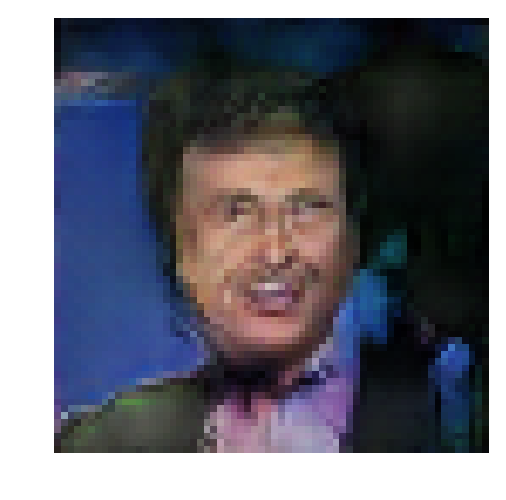

INFO:root:speed: 2204.1931288182354 samples/s
INFO:root:discriminator loss = 0.019167, generator loss = 6.339241, binary training acc = 1.000000 at iter 0 epoch 17
INFO:root:speed: 914.5513566551738 samples/s
INFO:root:discriminator loss = 0.052138, generator loss = 5.344708, binary training acc = 0.999290 at iter 10 epoch 17
INFO:root:speed: 927.1389108592862 samples/s
INFO:root:discriminator loss = 0.043301, generator loss = 7.305465, binary training acc = 0.998884 at iter 20 epoch 17
INFO:root:speed: 914.3083850487408 samples/s
INFO:root:discriminator loss = 0.038366, generator loss = 6.775134, binary training acc = 0.998992 at iter 30 epoch 17
INFO:root:speed: 927.1805414516541 samples/s
INFO:root:discriminator loss = 0.030663, generator loss = 5.833347, binary training acc = 0.999238 at iter 40 epoch 17
INFO:root:speed: 914.3114992523664 samples/s
INFO:root:discriminator loss = 0.026657, generator loss = 6.234416, binary training acc = 0.998928 at iter 50 epoch 17
INFO:root:speed:

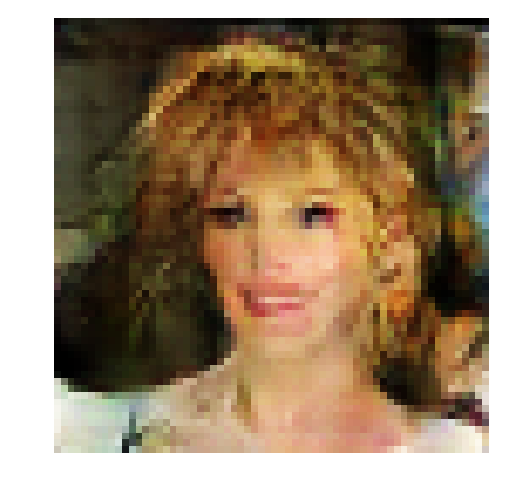

INFO:root:speed: 2285.335058743402 samples/s
INFO:root:discriminator loss = 0.261708, generator loss = 5.290507, binary training acc = 0.929688 at iter 0 epoch 18
INFO:root:speed: 927.6066693159631 samples/s
INFO:root:discriminator loss = 0.240562, generator loss = 6.034729, binary training acc = 0.967330 at iter 10 epoch 18
INFO:root:speed: 901.6554679994895 samples/s
INFO:root:discriminator loss = 0.211342, generator loss = 5.518024, binary training acc = 0.968378 at iter 20 epoch 18
INFO:root:speed: 927.5297451012235 samples/s
INFO:root:discriminator loss = 0.345338, generator loss = 6.791328, binary training acc = 0.968750 at iter 30 epoch 18
INFO:root:speed: 914.6167941532224 samples/s
INFO:root:discriminator loss = 0.119656, generator loss = 6.320795, binary training acc = 0.967226 at iter 40 epoch 18
INFO:root:speed: 914.6230267842844 samples/s
INFO:root:discriminator loss = 0.091002, generator loss = 5.808770, binary training acc = 0.969669 at iter 50 epoch 18
INFO:root:speed: 

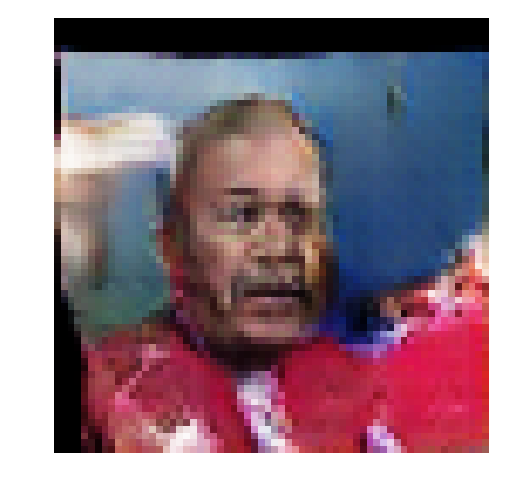

INFO:root:speed: 2285.3156026255524 samples/s
INFO:root:discriminator loss = 0.048188, generator loss = 6.038405, binary training acc = 1.000000 at iter 0 epoch 19
INFO:root:speed: 901.4011376839334 samples/s
INFO:root:discriminator loss = 0.044038, generator loss = 6.441430, binary training acc = 0.990767 at iter 10 epoch 19
INFO:root:speed: 901.0410819120762 samples/s
INFO:root:discriminator loss = 0.049914, generator loss = 6.506815, binary training acc = 0.994048 at iter 20 epoch 19
INFO:root:speed: 901.1348502447245 samples/s
INFO:root:discriminator loss = 0.089019, generator loss = 5.686661, binary training acc = 0.994456 at iter 30 epoch 19
INFO:root:speed: 914.2647884253835 samples/s
INFO:root:discriminator loss = 0.103899, generator loss = 7.944370, binary training acc = 0.994855 at iter 40 epoch 19
INFO:root:speed: 888.8826723886725 samples/s
INFO:root:discriminator loss = 0.052603, generator loss = 5.659719, binary training acc = 0.994792 at iter 50 epoch 19
INFO:root:speed:

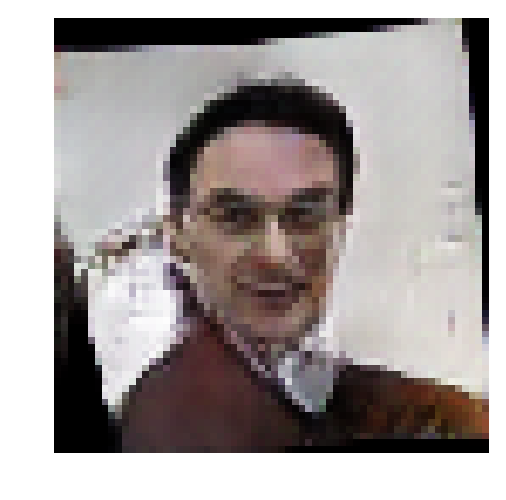

INFO:root:speed: 2285.549097906325 samples/s
INFO:root:discriminator loss = 0.057736, generator loss = 6.415337, binary training acc = 0.992188 at iter 0 epoch 20
INFO:root:speed: 901.7523934937282 samples/s
INFO:root:discriminator loss = 0.052804, generator loss = 5.524153, binary training acc = 0.999290 at iter 10 epoch 20
INFO:root:speed: 901.4374618014278 samples/s
INFO:root:discriminator loss = 0.057991, generator loss = 7.265997, binary training acc = 0.999256 at iter 20 epoch 20
INFO:root:speed: 888.823808325497 samples/s
INFO:root:discriminator loss = 0.018512, generator loss = 5.387253, binary training acc = 0.999496 at iter 30 epoch 20
INFO:root:speed: 901.3284982304866 samples/s
INFO:root:discriminator loss = 0.017446, generator loss = 6.021198, binary training acc = 0.999619 at iter 40 epoch 20
INFO:root:speed: 888.8856157964973 samples/s
INFO:root:discriminator loss = 0.030878, generator loss = 6.203422, binary training acc = 0.999694 at iter 50 epoch 20
INFO:root:speed: 8

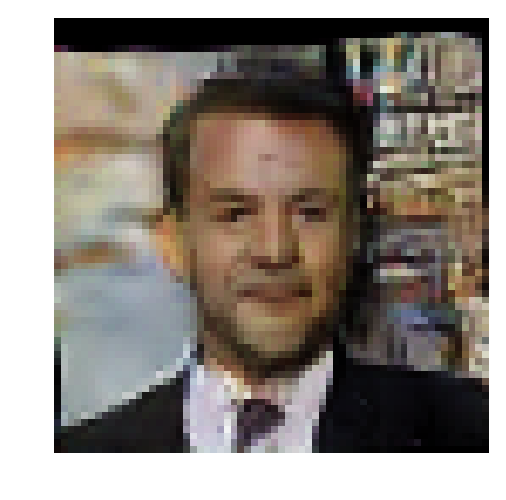

INFO:root:speed: 2284.7515192782366 samples/s
INFO:root:discriminator loss = 0.022970, generator loss = 6.603724, binary training acc = 1.000000 at iter 0 epoch 21
INFO:root:speed: 914.249219210321 samples/s
INFO:root:discriminator loss = 0.028311, generator loss = 5.646935, binary training acc = 0.998580 at iter 10 epoch 21
INFO:root:speed: 927.9241166181564 samples/s
INFO:root:discriminator loss = 0.045475, generator loss = 6.640116, binary training acc = 0.999256 at iter 20 epoch 21
INFO:root:speed: 914.2367642200554 samples/s
INFO:root:discriminator loss = 0.023861, generator loss = 5.952949, binary training acc = 0.999496 at iter 30 epoch 21
INFO:root:speed: 914.283472183432 samples/s
INFO:root:discriminator loss = 0.019123, generator loss = 6.305985, binary training acc = 0.999619 at iter 40 epoch 21
INFO:root:speed: 913.8819395977953 samples/s
INFO:root:discriminator loss = 0.013380, generator loss = 6.400267, binary training acc = 0.999694 at iter 50 epoch 21
INFO:root:speed: 9

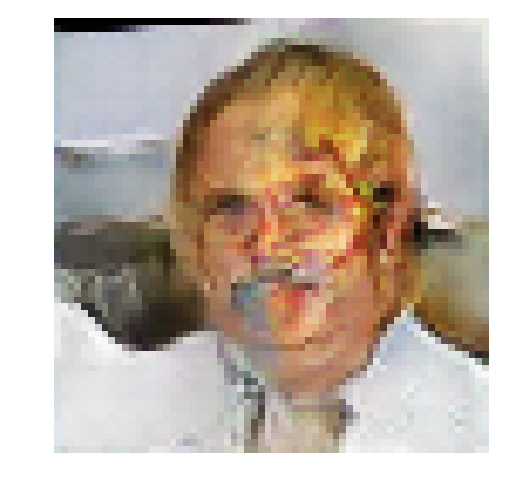

INFO:root:speed: 2133.369276864266 samples/s
INFO:root:discriminator loss = 0.024311, generator loss = 7.040029, binary training acc = 1.000000 at iter 0 epoch 22
INFO:root:speed: 940.855406400056 samples/s
INFO:root:discriminator loss = 0.024454, generator loss = 5.871789, binary training acc = 1.000000 at iter 10 epoch 22
INFO:root:speed: 901.4011376839334 samples/s
INFO:root:discriminator loss = 0.014391, generator loss = 6.484775, binary training acc = 1.000000 at iter 20 epoch 22
INFO:root:speed: 913.9254997157127 samples/s
INFO:root:discriminator loss = 0.024408, generator loss = 6.018391, binary training acc = 0.999748 at iter 30 epoch 22
INFO:root:speed: 914.6510746752804 samples/s
INFO:root:discriminator loss = 0.020638, generator loss = 6.725163, binary training acc = 0.999809 at iter 40 epoch 22
INFO:root:speed: 901.4011376839334 samples/s
INFO:root:discriminator loss = 0.085619, generator loss = 5.628772, binary training acc = 0.999540 at iter 50 epoch 22
INFO:root:speed: 9

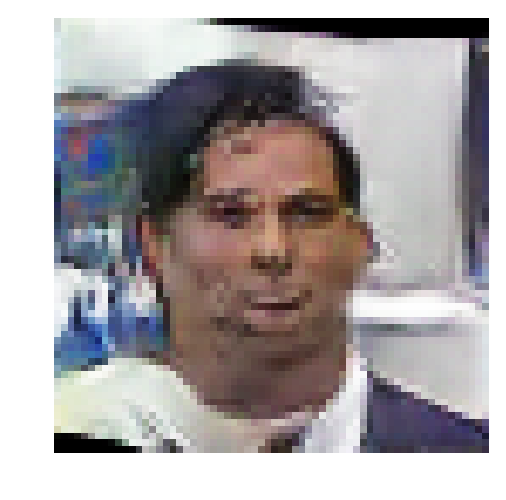

INFO:root:speed: 2285.7826409053364 samples/s
INFO:root:discriminator loss = 0.015178, generator loss = 6.959634, binary training acc = 1.000000 at iter 0 epoch 23
INFO:root:speed: 876.7042885556865 samples/s
INFO:root:discriminator loss = 0.021322, generator loss = 5.891381, binary training acc = 1.000000 at iter 10 epoch 23
INFO:root:speed: 901.0804017401579 samples/s
INFO:root:discriminator loss = 0.011050, generator loss = 7.034802, binary training acc = 0.999628 at iter 20 epoch 23
INFO:root:speed: 913.8881622175543 samples/s
INFO:root:discriminator loss = 0.014089, generator loss = 6.668487, binary training acc = 0.999748 at iter 30 epoch 23
INFO:root:speed: 927.5682056137417 samples/s
INFO:root:discriminator loss = 0.015079, generator loss = 6.514521, binary training acc = 0.999809 at iter 40 epoch 23
INFO:root:speed: 901.4011376839334 samples/s
INFO:root:discriminator loss = 0.007780, generator loss = 6.940419, binary training acc = 0.999847 at iter 50 epoch 23
INFO:root:speed:

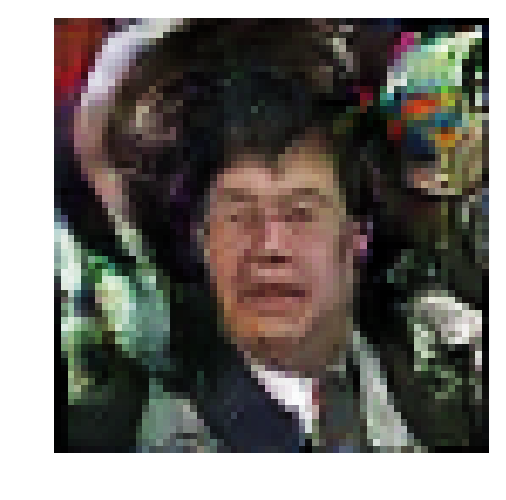

INFO:root:speed: 2285.5880184253324 samples/s
INFO:root:discriminator loss = 0.010541, generator loss = 6.615997, binary training acc = 1.000000 at iter 0 epoch 24
INFO:root:speed: 914.2772441792346 samples/s
INFO:root:discriminator loss = 0.013973, generator loss = 5.846147, binary training acc = 1.000000 at iter 10 epoch 24
INFO:root:speed: 914.6791242865661 samples/s
INFO:root:discriminator loss = 0.027776, generator loss = 5.971475, binary training acc = 0.999628 at iter 20 epoch 24
INFO:root:speed: 914.6853577671541 samples/s
INFO:root:discriminator loss = 0.008421, generator loss = 6.594909, binary training acc = 0.999748 at iter 30 epoch 24
INFO:root:speed: 914.6354923012447 samples/s
INFO:root:discriminator loss = 0.012592, generator loss = 6.270511, binary training acc = 0.999809 at iter 40 epoch 24
INFO:root:speed: 888.5590164911189 samples/s
INFO:root:discriminator loss = 0.012977, generator loss = 6.898922, binary training acc = 0.999847 at iter 50 epoch 24
INFO:root:speed:

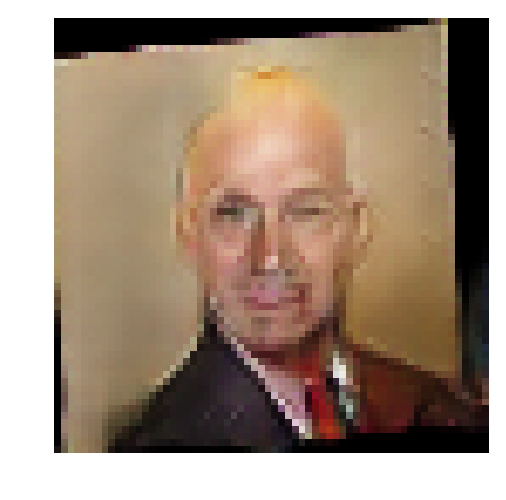

INFO:root:speed: 2285.4907196131185 samples/s
INFO:root:discriminator loss = 0.004990, generator loss = 7.537370, binary training acc = 1.000000 at iter 0 epoch 25
INFO:root:speed: 914.3146134772064 samples/s
INFO:root:discriminator loss = 0.014752, generator loss = 6.599904, binary training acc = 1.000000 at iter 10 epoch 25
INFO:root:speed: 914.3519858300974 samples/s
INFO:root:discriminator loss = 0.010939, generator loss = 6.831006, binary training acc = 1.000000 at iter 20 epoch 25
INFO:root:speed: 914.2772441792346 samples/s
INFO:root:discriminator loss = 0.011469, generator loss = 6.514076, binary training acc = 1.000000 at iter 30 epoch 25
INFO:root:speed: 927.5329500221142 samples/s
INFO:root:discriminator loss = 0.013706, generator loss = 6.157610, binary training acc = 1.000000 at iter 40 epoch 25
INFO:root:speed: 901.1318251551763 samples/s
INFO:root:discriminator loss = 0.008603, generator loss = 6.530869, binary training acc = 1.000000 at iter 50 epoch 25
INFO:root:speed:

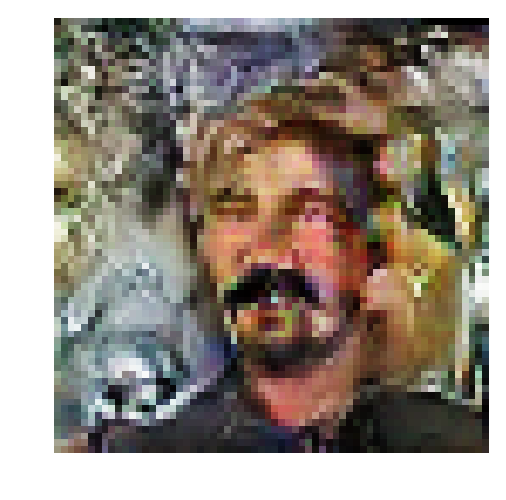

INFO:root:speed: 2208.491003480135 samples/s
INFO:root:discriminator loss = 0.010578, generator loss = 6.975229, binary training acc = 1.000000 at iter 0 epoch 26
INFO:root:speed: 901.8341905897768 samples/s
INFO:root:discriminator loss = 0.018336, generator loss = 6.950029, binary training acc = 1.000000 at iter 10 epoch 26
INFO:root:speed: 901.7614813272014 samples/s
INFO:root:discriminator loss = 0.004895, generator loss = 7.159352, binary training acc = 1.000000 at iter 20 epoch 26
INFO:root:speed: 901.7675399846142 samples/s
INFO:root:discriminator loss = 0.009336, generator loss = 6.731560, binary training acc = 1.000000 at iter 30 epoch 26
INFO:root:speed: 888.8767856315026 samples/s
INFO:root:discriminator loss = 0.010771, generator loss = 6.189943, binary training acc = 1.000000 at iter 40 epoch 26
INFO:root:speed: 901.3617898600119 samples/s
INFO:root:discriminator loss = 0.007193, generator loss = 7.259078, binary training acc = 1.000000 at iter 50 epoch 26
INFO:root:speed: 

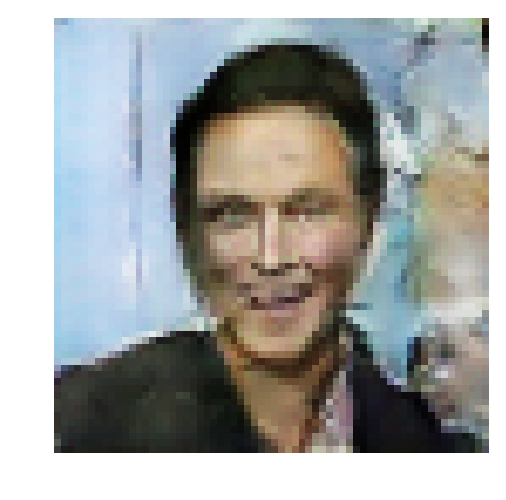

INFO:root:speed: 2285.7826409053364 samples/s
INFO:root:discriminator loss = 0.020099, generator loss = 7.845318, binary training acc = 1.000000 at iter 0 epoch 27
INFO:root:speed: 914.2741302089543 samples/s
INFO:root:discriminator loss = 0.010664, generator loss = 6.680425, binary training acc = 1.000000 at iter 10 epoch 27
INFO:root:speed: 927.8792118907709 samples/s
INFO:root:discriminator loss = 0.012514, generator loss = 8.576719, binary training acc = 1.000000 at iter 20 epoch 27
INFO:root:speed: 914.2772441792346 samples/s
INFO:root:discriminator loss = 0.015073, generator loss = 7.651245, binary training acc = 1.000000 at iter 30 epoch 27
INFO:root:speed: 914.2803581707271 samples/s
INFO:root:discriminator loss = 0.012764, generator loss = 7.147291, binary training acc = 1.000000 at iter 40 epoch 27
INFO:root:speed: 914.6230267842844 samples/s
INFO:root:discriminator loss = 0.013591, generator loss = 6.756032, binary training acc = 1.000000 at iter 50 epoch 27
INFO:root:speed:

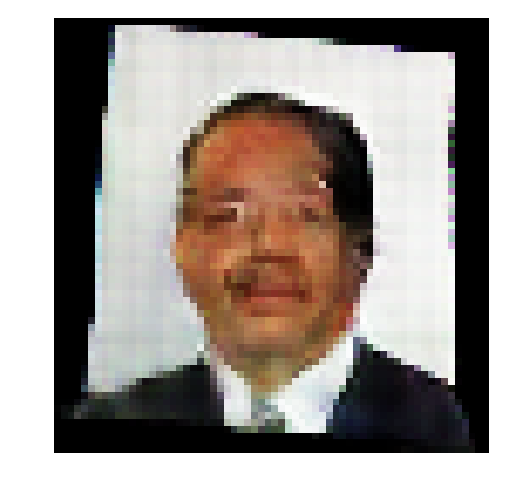

INFO:root:speed: 2207.2742940779845 samples/s
INFO:root:discriminator loss = 0.070455, generator loss = 7.740113, binary training acc = 0.992188 at iter 0 epoch 28
INFO:root:speed: 901.0713276290923 samples/s
INFO:root:discriminator loss = 0.086940, generator loss = 6.298461, binary training acc = 0.980824 at iter 10 epoch 28
INFO:root:speed: 914.2461054309399 samples/s
INFO:root:discriminator loss = 0.104909, generator loss = 6.366910, binary training acc = 0.970238 at iter 20 epoch 28
INFO:root:speed: 941.5649380031217 samples/s
INFO:root:discriminator loss = 0.168989, generator loss = 7.213571, binary training acc = 0.976058 at iter 30 epoch 28
INFO:root:speed: 969.6726739418634 samples/s
INFO:root:discriminator loss = 2.805248, generator loss = 1.517701, binary training acc = 0.936547 at iter 40 epoch 28
INFO:root:speed: 914.6760075781325 samples/s
INFO:root:discriminator loss = 1.067438, generator loss = 12.389589, binary training acc = 0.928462 at iter 50 epoch 28
INFO:root:speed

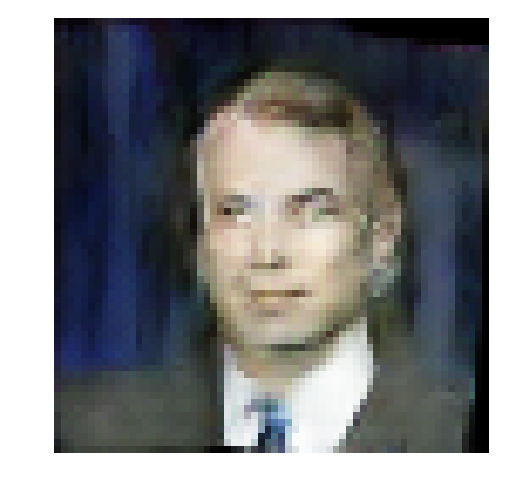

INFO:root:speed: 2367.907413288169 samples/s
INFO:root:discriminator loss = 0.063208, generator loss = 6.982102, binary training acc = 1.000000 at iter 0 epoch 29
INFO:root:speed: 901.7675399846142 samples/s
INFO:root:discriminator loss = 0.078039, generator loss = 5.668583, binary training acc = 0.982244 at iter 10 epoch 29
INFO:root:speed: 901.4102184388589 samples/s
INFO:root:discriminator loss = 0.054637, generator loss = 5.775732, binary training acc = 0.986607 at iter 20 epoch 29
INFO:root:speed: 888.6266705067218 samples/s
INFO:root:discriminator loss = 0.068052, generator loss = 5.603424, binary training acc = 0.989667 at iter 30 epoch 29
INFO:root:speed: 901.3708698221673 samples/s
INFO:root:discriminator loss = 0.069703, generator loss = 6.962947, binary training acc = 0.991235 at iter 40 epoch 29
INFO:root:speed: 888.8208653269893 samples/s
INFO:root:discriminator loss = 0.126035, generator loss = 7.998218, binary training acc = 0.991268 at iter 50 epoch 29
INFO:root:speed: 

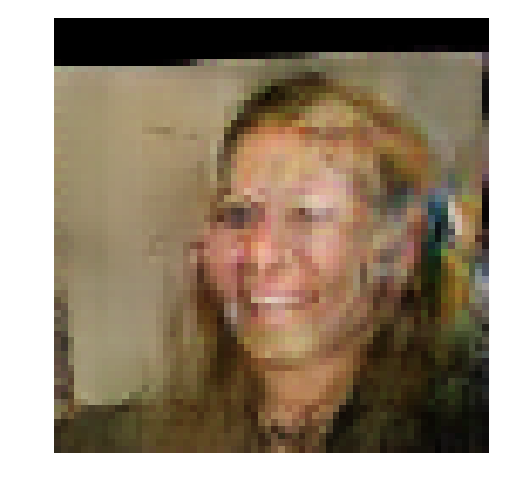

In [27]:

from datetime import datetime
import time
import logging

real_label = nd.ones((batch_size,), ctx=ctx)
fake_label = nd.zeros((batch_size,),ctx=ctx)

def facc(label, pred):
    pred = pred.ravel()
    label = label.ravel()
    return ((pred > 0.5) == label).mean()
metric = mx.metric.CustomMetric(facc)

stamp =  datetime.now().strftime('%Y_%m_%d-%H_%M')
logging.basicConfig(level=logging.DEBUG)

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    train_data.reset()
    iter = 0
    for batch in train_data:
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        data = batch.data[0].as_in_context(ctx)
        latent_z = mx.nd.random_normal(0, 1, shape=(batch_size, latent_z_size, 1, 1), ctx=ctx)

        with autograd.record():
            # train with real image
            output = netD(data).reshape((-1, 1))
            errD_real = loss(output, real_label)
            metric.update([real_label,], [output,])

            # train with fake image
            fake = netG(latent_z)
            output = netD(fake.detach()).reshape((-1, 1))
            errD_fake = loss(output, fake_label)
            errD = errD_real + errD_fake
            errD.backward()
            metric.update([fake_label,], [output,])

        trainerD.step(batch.data[0].shape[0])

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        with autograd.record():
            fake = netG(latent_z)
            output = netD(fake).reshape((-1, 1))
            errG = loss(output, real_label)
            errG.backward()

        trainerG.step(batch.data[0].shape[0])

        # Print log infomation every ten batches
        if iter % 10 == 0:
            name, acc = metric.get()
            logging.info('speed: {} samples/s'.format(batch_size / (time.time() - btic)))
            logging.info('discriminator loss = %f, generator loss = %f, binary training acc = %f at iter %d epoch %d'
                     %(nd.mean(errD).asscalar(),
                       nd.mean(errG).asscalar(), acc, iter, epoch))
        iter = iter + 1
        btic = time.time()

    name, acc = metric.get()
    metric.reset()
    logging.info('\nbinary training acc at epoch %d: %s=%f' % (epoch, name, acc))
    logging.info('time: %f' % (time.time() - tic))

#     Visualize one generated image for each epoch
    fake_img = fake[0]
    visualize(fake_img)
    plt.show()

INFO:root:
binary training acc at epoch 1: facc=0.857563
INFO:root:time: 85.033413


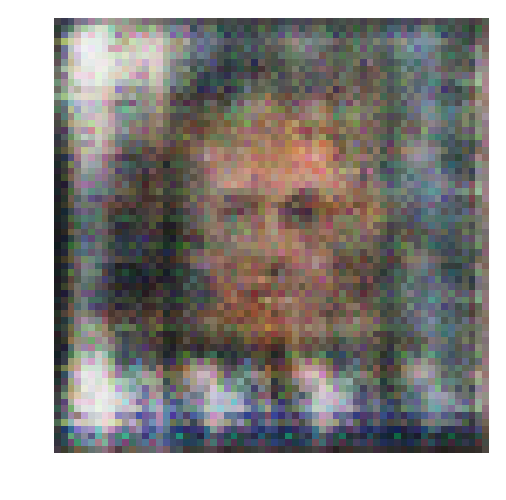

In [18]:
logging.info('\nbinary training acc at epoch %d: %s=%f' % (epoch, name, acc))
logging.info('time: %f' % (time.time() - tic))

    # Visualize one generated image for each epoch
fake_img = fake[0]
visualize(fake_img)
plt.show()